In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! ls 'drive/My Drive/nlp'

balanced_train_data.csv  gpt2-finetune.ipynb  output_dir  train_filtered.csv


In [3]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

11

In [4]:
# hugging face install
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 49.1 MB/s 
     |████████████████████████████████| 3.3 MB 35.8 MB/s 
     |████████████████████████████████| 59 kB 7.2 MB/s 
     |████████████████████████████████| 895 kB 49.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification,
                          GPT2LMHeadModel,
                          AutoTokenizer)


In [6]:
import tqdm 

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

import shutil

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cuda:0


In [7]:
path = 'drive/My Drive/nlp/train_filtered.csv'
# path_test = 'drive/My Drivenlp/balanced_train_data.csv'

In [8]:
data = pd.read_csv(path)
# data_balanced_test = pd.read_csv(path_test)

In [9]:
# data_drop : left Genre Lyrics
data_drop = data.drop(['Artist', 'Song', 'Language'], axis=1)


# 중복 데이터 제거
data_drop.drop_duplicates('Lyrics')


,Genre,Lyrics
0,Rock,"It starts with pain, followed by hate\nFueled ..."
1,Rock,Freedom!\nAlone again again alone\nPatiently w...
2,Rock,"Biting the hand that feeds you, lying to the v..."
3,Rock,You say you know just who I am\nBut you can't ...
4,Rock,My heart is beating faster can't control these...
...,...,...
249943,R&B,I'm the best friend he's got I'd give him the ...
249944,Pop,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
249945,Pop,Forgive me for the things That I never said to...
249946,Indie,The day they found a cure for AIDS The day the...


In [10]:
## data split
## using 200,000 takes too much time
## use 1/10

from sklearn.model_selection import train_test_split

a_data, b_data = train_test_split(data_drop, test_size=0.1, random_state=123)
train_data, test_data = train_test_split(b_data, test_size=0.3, random_state=123)

# train_data, test_data = train_test_split(data_drop, test_size=0.3, random_state=123)

In [11]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [11]:
set_seed(123)
epochs = 2
batch_size = 16

# Pad or truncate text sequences to a specific length
# 500??
max_length = 200

model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'Rock': 0, 'Pop': 1, 'Metal': 2, 'Jazz': 3, 'Folk': 4, 'Indie': 5, 'R&B': 6, 'Hip-Hop': 7, 'Electronic': 8, 'Country': 9}
n_labels = len(labels_ids)


In [12]:
class Gpt2ClassificationCollator(object):

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  global model

  predictions_labels = []
  true_labels = []
  total_loss = 0

  model.train()

  for batch in dataloader:
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    model.zero_grad()
    outputs = model(**batch)
    loss, logits = outputs[:2]
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer_.step()
    scheduler_.step()
    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  avg_epoch_loss = total_loss / len(dataloader)
  
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0

  model.eval()
  for batch in dataloader:

    true_labels += batch['labels'].numpy().flatten().tolist()

    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  return true_labels, predictions_labels, avg_epoch_loss

In [13]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda:0`


In [14]:
# make dataset
class SongLyrics(Dataset):  
    def __init__(self, data, truncate=False, gpt2_type="gpt2", max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.texts = []
        self.labels = []

        for row in data['Lyrics']:
          #print(row)
          self.texts.append(row)
        
        for gen in data['Genre']:
          #print(data_drop[data_drop['Lyrics']==row]['Genre'])
          self.labels.append(gen)

        self.lyrics_count = len(self.labels)
        
    def __len__(self):
        return self.lyrics_count

    def __getitem__(self, item):
        #return self.lyrics[item]
        return {'text':self.texts[item],
                'label':self.labels[item]}
    

In [15]:
train_dataset = SongLyrics(train_data, truncate=True, gpt2_type="gpt2")
test_dataset = SongLyrics(test_data, truncate=True, gpt2_type="gpt2")

In [16]:
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


# dataloader

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(test_dataloader))


Created `train_dataloader` with 1094 batches!

Created `eval_dataloader` with 469 batches!


In [17]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )


In [18]:
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'test_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}


## train
for epoch in range(epochs):
  print()
  print('Training on batches : {} epoch'.format(epoch+1))
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Test results')
  test_labels, test_predict, test_loss = validation(test_dataloader, device)
  val_acc = accuracy_score(test_labels, test_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, test_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['test_loss'].append(test_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)



## save fine tuned model
import os

output_dir = 'drive/My Drive/nlp/output_dir'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Training on batches : 1 epoch
Test results
  train_loss: 1.34365 - val_loss: 1.16028 - train_acc: 0.51943 - valid_acc: 0.57794


Training on batches : 2 epoch
Test results
  train_loss: 1.11300 - val_loss: 1.13367 - train_acc: 0.59168 - valid_acc: 0.59221

Saving model to drive/My Drive/nlp/output_dir


('drive/My Drive/nlp/output_dir/tokenizer_config.json',
 'drive/My Drive/nlp/output_dir/special_tokens_map.json',
 'drive/My Drive/nlp/output_dir/vocab.json',
 'drive/My Drive/nlp/output_dir/merges.txt',
 'drive/My Drive/nlp/output_dir/added_tokens.json')

In [19]:
output_dir = 'drive/My Drive/nlp/output_dir'

tokenizer = AutoTokenizer.from_pretrained(output_dir)

model = GPT2ForSequenceClassification.from_pretrained(output_dir)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Model loaded to `cuda:0`


In [20]:
## print final f1-score
true_labels, predictions_labels, avg_epoch_loss = validation(test_dataloader, device)

# Create and print the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
print(evaluation_report)

              precision    recall  f1-score   support

        Rock       0.57      0.79      0.66      3207
         Pop       0.69      0.55      0.61      2581
       Metal       0.58      0.46      0.51       573
        Jazz       0.43      0.35      0.38       417
        Folk       0.75      0.01      0.02       251
       Indie       0.00      0.00      0.00       223
         R&B       0.27      0.04      0.07        80
     Hip-Hop       0.66      0.85      0.74        54
  Electronic       0.05      0.02      0.03        50
     Country       0.39      0.24      0.30        63

    accuracy                           0.59      7499
   macro avg       0.44      0.33      0.33      7499
weighted avg       0.58      0.59      0.56      7499



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


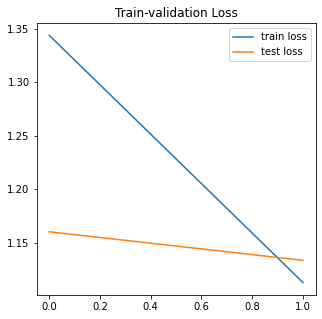

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

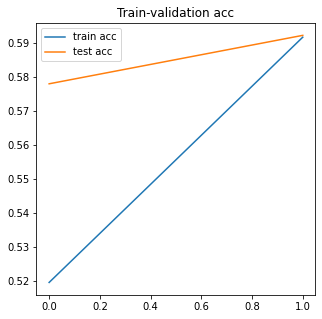

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
from google.colab import files


plt.figure(figsize=(5,5))
plt.title('Train-validation Loss')
plt.plot(all_loss['train_loss'], label='train loss')
plt.plot(all_loss['test_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('Train-validation Loss_0.1data.png', dpi=300)
files.download("Train-validation Loss_0.1data.png") 

plt.figure(figsize=(5,5))
plt.title('Train-validation acc')
plt.plot(all_acc['train_acc'], label='train acc')
plt.plot(all_acc['val_acc'], label='test acc')
plt.legend()
plt.show()
plt.savefig('Train-validation acc_0.1data.png', dpi=300)
files.download("Train-validation acc_0.1data.png")

# **check with balanced test data**

In [26]:
path_test = 'drive/My Drive/nlp/balanced_train_data.csv'
data_balanced_test = pd.read_csv(path_test)

balanced_data = SongLyrics(data_balanced_test, truncate=True, gpt2_type="gpt2")

print('Dealing with Test...')
balanced_dataloader = DataLoader(balanced_data, batch_size=16, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(balanced_dataloader))

Dealing with Test...
Created `eval_dataloader` with 1047 batches!


In [27]:
## print final f1-score
true_labels, predictions_labels, avg_epoch_loss = validation(balanced_dataloader, device)

# Create and print the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
print(evaluation_report)

              precision    recall  f1-score   support

        Rock       0.14      0.55      0.22      1683
         Pop       0.23      0.17      0.19      1683
       Metal       0.54      0.52      0.53      1683
        Jazz       0.34      0.16      0.22      1683
        Folk       0.14      0.00      0.00      1683
       Indie       0.25      0.00      0.00      1683
         R&B       0.20      0.01      0.02      1683
     Hip-Hop       0.37      0.85      0.51      1683
  Electronic       0.08      0.06      0.07      1683
     Country       0.26      0.17      0.21      1594

    accuracy                           0.25     16741
   macro avg       0.25      0.25      0.20     16741
weighted avg       0.25      0.25      0.20     16741



# **Check only 30 songs**

In [ ]:
a_data, b_data = train_test_split(test_data, test_size=0.0005, random_state=123)

In [ ]:
b_data

,Genre,Lyrics
208906,Rock,Life has been unfaithful\nAnd it all promised ...
125507,Pop,Tell me what happened this time\nMade you come...
138399,Metal,Night has fallen\nAnd the darkness hides an ev...
25663,Rock,Why we're always headed for disaster\nWas I on...
136387,Rock,Walking down an empty road\nI saw a man in old...
73221,Pop,[Kokane]\nIn this times\nOf hate and pain\nWe ...
120761,Pop,This has been no walk in the park\nI feel like...
32439,Pop,"You, you like driving on a Sunday\nYou, you li..."
80782,Pop,"Loving you, I thought I couldn't get no higher..."
110417,Rock,I hear the drums echoing tonight\nBut she hear...


In [ ]:
test_dataset30 = SongLyrics(b_data, truncate=True, gpt2_type="gpt2")

In [ ]:
test_dataset30

In [ ]:

print('Dealing with Train...')
# Create pytorch dataset.
# 이미 pandas로 dataset을 받아왔으니까 괜찮지 않을까...?
# train_dataset을 새로 정의해야함..

print('Dealing with Test...')
# Create pytorch dataset.
# Move pytorch dataset into dataloader.
test_dataloader30 = DataLoader(test_dataset30, batch_size=16, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(test_dataloader30))


Dealing with Train...
Dealing with Test...
Created `eval_dataloader` with 3 batches!


In [ ]:
true_labels, predictions_labels, avg_epoch_loss = validation(test_dataloader30, device)
val_acc = accuracy_score(test_labels, test_predict)

# Print loss and accuracy values to see how training evolves.
print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, test_loss, train_acc, val_acc))

  train_loss: 1.05260 - val_loss: 1.05961 - train_acc: 0.60632 - valid_acc: 0.60661


In [ ]:
print(true_labels)
print(predictions_labels)

[0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 4, 5, 1, 1, 0, 0, 1, 5, 1, 0, 2, 0, 0, 0, 1, 1, 2, 0, 2, 0, 1, 0, 0]
[0, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 3, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 2, 1, 0, 1, 1, 1, 0, 0, 2, 0, 1, 1, 0]
